In [6]:
using JLD, Plots, Combinatorics
using HDF5
using Base.Iterators
gr()

Plots.GRBackend()

In [22]:
arxname="../JLDFiles/Evocada/CSDEvocada_3R7.jld"
data=load(arxname)
arxotro="../BRWFiles/LFP_Promedio_050815_3R7_converted.h5"
arxaux=h5open(arxotro)
#h5close(arxaux)
cresp=read(arxaux["CanalesRespuesta"])
csatu=read(arxaux["CanalesSaturados"]);

In [75]:
cresp

203×2 Array{Int64,2}:
 16  28
 17  28
 16  29
 17  29
 15  30
 16  30
 17  30
 15  31
 16  31
 17  31
 15  32
 16  32
 17  32
  ⋮    
 16  64
 17  64
 18  64
 31  64
 36  64
 37  64
 38  64
 39  64
 40  64
 43  64
 45  64
 47  64

In [77]:
freq=7.022
csd=(data["CSD"]["Trancazo_1"]+data["CSD"]["Trancazo_2"]+data["CSD"]["Trancazo_3"])./3
(h,w,nmax)=size(csd)
epsi=21
  ss=[-1,0,1]

3-element Array{Int64,1}:
 -1
  0
  1

In [130]:
size(csd)

(62, 62, 248)

In [24]:
function simboliza(x, delta=epsi)
    result=0
    if x>delta
        result=1
    elseif x< -delta
        result=-1
    else
        result=0
    end
    return result
end

simboliza (generic function with 2 methods)

In [25]:
csdsymb=map(x->simboliza(x), csd);

In [78]:
xs=csdsymb[16,28,:];
ys=[1]

1-element Array{Int64,1}:
 1

In [26]:
function problock(xxs::Array, yys::Array)
    # calculamos la prob exp de encontrar el array yys en el array xxs
    lx=length(xxs)
    ly=length(yys)
    lp=lx-ly+1
    result=0
    if(lx<ly)
        error("tuabueliuta")
    else
        for j=1:lp
            if xxs[j:j+ly-1]==yys
                result+=1
            end
        end
    end
    return result/lp
end

problock (generic function with 1 method)

In [66]:
function ncartprod(ss, n)
    argumento=ntuple(i->ss, n)
    result=product(argumento...)
    return(result)
end

ncartprod (generic function with 1 method)

In [67]:
function ncartprodR(ss, n)
# okey, esto no funciona nada bien. Muuuy lento y usa mas RAM
    # Y PRODUCE UN OBJETO monstruoso en RAM
    result=[]
    if n==1
        for s in ss
            push!(result, [s])
        end
        return result
    else
        aux=ncartprodR(ss, n-1)
        for w in aux
            for s in ss
                vv=vcat(s, w)
                push!(result, vv)
            end
        end
        return result
    end
end

ncartprodR (generic function with 1 method)

In [68]:
n=3
@time a=ncartprodR(ss, n);
@time b=ncartprod(ss, n);

  0.027927 seconds (20.66 k allocations: 944.299 KiB)
  0.074009 seconds (115.20 k allocations: 5.773 MiB, 8.37% gc time)


In [69]:
Base.summarysize(a), Base.summarysize(b)
length(b)

27

In [70]:
# con permiso de StackOverflow oooo.key takes lot to compile!
issubvec(v,big) = any([v == big[i:(i+length(v)-1)] for i=1:(length(big)-length(v)+1)])

issubvec (generic function with 1 method)

In [71]:
function allprobsn(xxs, ss, n)
    result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        aux=problock(xxs, pr)
        if aux>0
            result[pr]= aux
        else
            push!(malas, pr)
        end
    end
    return (result, malas)
end


function allprobsn(xxs, ss, n, vacias)
    
    #ush tambien muy ineficiente. Sigue siendo mejor buscar a lo pendejo???
            result=Dict{Array, Float64}()
    palabras=ncartprod(ss, n)
    malas=Set()
    for p in palabras
        pr=[p...]
        tanteada=any(issubvec(v, pr) for v in vacias)
        if tanteada
         #   print(pr, " esta tanteada!!  ")
            aux=0
        else
            aux=problock(xxs, pr)
            if aux>0
                result[pr]= aux
            else
                push!(malas, pr)
            end
        end # sobre tanteada
    end #sobre palabras
    return (result, malas)
end

allprobsn (generic function with 2 methods)

In [86]:
r[2]

Set(Any[[0, -1, 1, 0, 1], [-1, 1, 0, -1, -1], [0, -1, -1, 0, 0], [1, 1, 1, 0, 1], [-1, -1, 0, 1, -1], [-1, -1, -1, 0, 1], [-1, 0, 1, -1, 0], [1, -1, 1, 0, -1], [1, 1, 0, 1, -1], [1, 0, -1, 0, -1]  …  [1, -1, 0, 1, 0], [0, 1, 1, -1, -1], [-1, 0, 1, 0, 1], [0, -1, 0, 1, -1], [0, 0, -1, 1, 1], [0, 1, 1, 0, -1], [-1, 0, 0, 1, -1], [-1, -1, 1, 0, -1], [-1, -1, 1, -1, 1], [-1, 1, 0, -1, 1], [0, 1, 0, -1, 0]])

In [73]:
function allprobsR(xxs, ss, n)
#not reaaalyy good. Actually preeeety bad
     result=Dict{Array, Float64}()
    if n==1
        palabras=ncartprod(ss, n)
        for p in palabras
            pr=[p...]
            result[pr]=problock(xxs, pr)
        end
    
    else
        
        auxres=allprobsR(xxs,ss,n-1)
        vacias=Set()
        for v in keys(auxres)
            if auxres[v]==0
                push!(vacias, v)
            end
        end
        
        palabras=ncartprod(ss, n)
        for p in palabras
            pr=[p...]
            tienemala=any(issubvec(v, pr) for v in vacias)
            if tienemala
                result[pr]=0
            else
                result[pr]=problock(xxs, pr)
            end
        end
        
        end  # cierra sobre n
    
    return result
end
                
                
    
    

allprobsR (generic function with 1 method)

Haciendo pruebas, al parecer matar el conjunto de malas con entre 3 y 4 letras es la forma más rapida. Ya despues de eso tiene que revisar palabrerias tan largas que no conviene.

In [102]:
@time (p, v3)=allprobsn(xs, ss, 3)

  0.000601 seconds (6.80 k allocations: 737.328 KiB)


(Dict{Array,Float64}([1, -1, -1]=>0.00813008,[0, -1, -1]=>0.00813008,[-1, -1, 0]=>0.0162602,[0, 0, 0]=>0.829268,[-1, 0, -1]=>0.00406504,[1, 0, 1]=>0.0121951,[1, 1, 1]=>0.0203252,[0, 1, -1]=>0.00406504,[0, 1, 0]=>0.00813008,[0, -1, 0]=>0.00406504…), Set(Any[[-1, 0, 1], [0, -1, 1], [-1, 1, 0], [-1, 1, -1], [1, 0, -1], [-1, -1, 1], [-1, 1, 1], [1, -1, 1], [1, -1, 0]]))

In [109]:
@time (p, v)=allprobsn(xs, ss, 11)

  5.072679 seconds (43.51 M allocations: 7.060 GiB, 48.79% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]=>0.00420168,[0, 0, 0, 0, 0, 1, -1, -1, -1, 0, -1]=>0.00420168,[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]=>0.00420168,[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1]=>0.00420168,[0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0]=>0.00420168,[1, 1, -1, -1, 0, 0, -1, -1, -1, 0, 0]=>0.00420168,[0, 0, 0, 0, 1, -1, -1, -1, 0, -1, 0]=>0.00420168,[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]=>0.00420168,[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]=>0.00420168,[1, 1, 1, -1, -1, 0, 0, -1, -1, -1, 0]=>0.00420168…), Set(Any[[-1, -1, -1, -1, -1, -1, -1, 1, 0, 1, -1], [1, -1, 0, -1, 1, -1, 1, -1, 1, 0, 0], [-1, 0, -1, 0, 0, 0, -1, 0, -1, 1, 0], [1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1], [1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [-1, -1, 0, 0, -1, -1, -1, 0, 1, 1, -1], [-1, 0, 0, -1, -1, -1, 1, 0, 1, 1, 0], [1, -1, 0, 1, 1, 0, 1, 1, 1, 0, -1], [-1, -1, -1, 0, 1, 0, 0, 1, 1, 1, 0], [-1, 1, -1, 0, 1, 1, -1, 0, 0, 0, 1]  …  [1, 0, -1, 0, 0, 1, 0, 0, -1, -1, -1], [0, 1, 1, -1, -1, 0, 1, -1, -1, -1, -1], [1, 1, 1, 1,

In [112]:
length(v4)

51

In [113]:
@time (ar, ir)=allprobsn(xs, ss,11, v3)

  1.164995 seconds (11.36 M allocations: 1.293 GiB, 36.10% gc time)


(Dict{Array,Float64}([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]=>0.00420168,[0, 0, 0, 0, 0, 1, -1, -1, -1, 0, -1]=>0.00420168,[0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0]=>0.00420168,[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1]=>0.00420168,[0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0]=>0.00420168,[1, 1, -1, -1, 0, 0, -1, -1, -1, 0, 0]=>0.00420168,[0, 0, 0, 0, 1, -1, -1, -1, 0, -1, 0]=>0.00420168,[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]=>0.00420168,[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]=>0.00420168,[1, 1, 1, -1, -1, 0, 0, -1, -1, -1, 0]=>0.00420168…), Set(Any[[1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 0], [1, -1, -1, -1, 0, 0, 1, 0, 0, -1, 0], [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1], [-1, -1, 0, -1, -1, -1, 0, 0, 0, -1, 0], [0, 0, -1, -1, 0, 0, 1, 1, 1, 1, 1], [-1, -1, -1, 0, -1, -1, 0, 0, 0, 1, 1], [0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, -1], [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1], [0, -1, 0, 0, -1, -1, 0, 0, 1, 1, -1]  …  [1, 1, 1, -1, -1, 0, 0, 0, 1, -1, -1], [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, -1], [1, 0, 1, 0, 1, 1, 0, 0, 

In [181]:
v3

Set(Any[[1, -1, -1], [-1, 1, 1], [-1, 1, 0], [1, 0, -1], [1, 0, 1], [-1, -1, 1], [1, 1, 1], [1, -1, 0], [0, 1, -1], [-1, 0, 1], [1, -1, 1], [1, 1, -1], [0, -1, 1], [-1, 1, -1], [-1, -1, -1]])

In [114]:
length(v)+length(p)º

177147

In [116]:
length(v)

177081

In [124]:
?collect

search: collect CoolLexCombinations get_color_palette



```
collect(element_type, collection)
```

Return an `Array` with the given element type of all items in a collection or iterable. The result has the same shape and number of dimensions as `collection`.

# Examples

```jldoctest
julia> collect(Float64, 1:2:5)
3-element Array{Float64,1}:
 1.0
 3.0
 5.0
```

---

```
collect(collection)
```

Return an `Array` of all items in a collection or iterator. For dictionaries, returns `Pair{KeyType, ValType}`. If the argument is array-like or is an iterator with the [`HasShape`](@ref IteratorSize) trait, the result will have the same shape and number of dimensions as the argument.

# Examples

```jldoctest
julia> collect(1:2:13)
7-element Array{Int64,1}:
  1
  3
  5
  7
  9
 11
 13
```


In [125]:
function shanonH_n(xxs, ss, n)
    (probs, v)=allprobsn(xxs,ss,n)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h
    return result
end

function shanonH_n(xxs, ss, n, v)
    (probs, v)=allprobsn(xxs,ss,n, v)
    h=0
    for q in values(probs)
        if q>0.00001
            h+=q*log(q)
        end
    end
    result=-h
    return result
end

shanonH_n (generic function with 2 methods)

In [119]:
0==0.000
lmax, nmax=size(cresp)

(203, 2)

In [122]:
struct hazfibrado
    renglon::Int
    columna::Int
    valores::Array{Float64, 1}
end

In [148]:
nm=div(nmax,2)
hhsn=Dict{Array{Int, 1}, Array{Float64,1}}()

nn=8
@time for l=1:lmax
        reng=cresp[l, 1]
        col=cresp[l, 2]
    if reng<63 && col <63
        xs=csdsymb[reng,col,:]
        hhsn[[reng,col]]=zeros(nn)
    
    for n=1:nn
        hhsn[[reng,col]][n]=shanonH_n(xs, ss, n)
    end
    end
    
end


 41.856824 seconds (440.89 M allocations: 57.896 GiB, 44.57% gc time)


In [149]:
pp=plot(key=false)
b=1:nn
for k in keys(hhsn)
    y=hhsn[k]
    scatter!(pp, b, y)
end

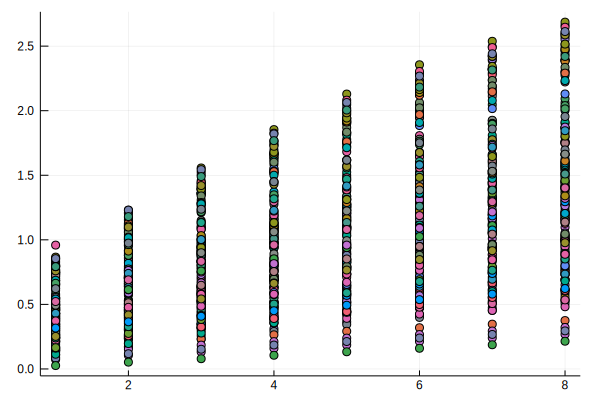

In [150]:
pp

In [ ]:
heatmap(hhsn[:,:,3], aspect_ratio=1)

In [ ]:
hhsn[:,:,1]==hhsn[:,:,4]

In [ ]:
allprobsn(xs, ss, 3)

In [ ]:
ss=[-1,0,1]
bla=[[q, j] for q in ss, j in ss ]

1-element Array{Int64,1}:
 1

In [46]:
problock(xs, [1]) , problock(xs, [0]),problock(xs, [-1])

(0.016129032258064516, 0.9556451612903226, 0.028225806451612902)

In [ ]:
heatmap(sumsym, aspect_ratio=1)

In [ ]:
?heatmap

In [68]:
a=[0,1]
n=[0, 1]
z=[1,1,0]
z2=[1,0,1]

3-element Array{Int64,1}:
 1
 0
 1

In [71]:
@time issubvec(a, z2)

  0.000008 seconds (9 allocations: 512 bytes)


true

In [72]:
@inbounds

LoadError: MethodError: no method matching @inbounds(::LineNumberNode, ::Module)
Closest candidates are:
  @inbounds(::LineNumberNode, ::Module, !Matched::Any) at essentials.jl:538

In [60]:
as=string(a)

"[0, 1]"